In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
train_dir='/content/drive/MyDrive/Flower Dataset/train'
val_dir='/content/drive/MyDrive/Flower Dataset/validation'
test_dir='/content/drive/MyDrive/Flower Dataset/test'

In [ ]:
BATCH_SIZE=8
IMG_SIZE=(128,128)
train_ds=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
            shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
val_ds=tf.keras.preprocessing.image_dataset_from_directory(val_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
test_ds=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
            shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 135 files belonging to 3 classes.
Found 135 files belonging to 3 classes.
Found 135 files belonging to 3 classes.


In [ ]:
class_names=train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'rose']


(8, 128, 128, 3)
(8,)
tf.Tensor([2 1 1 2 2 2 1 0], shape=(8,), dtype=int32)


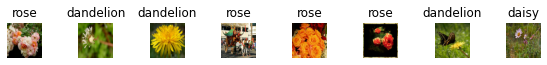

In [ ]:
# a single batch
# visualize
plt.figure(figsize=(10,6))
for image_batch,label_batch in train_ds.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    print(label_batch)
    for i in range(BATCH_SIZE):
        plt.subplot(8,8,i+1)
        plt.imshow(image_batch[i]/255.0) # float [0-1],int[0-255]
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

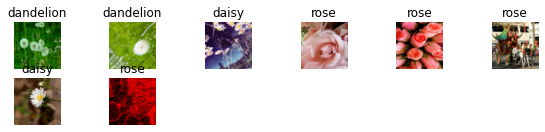

In [ ]:
# Data augmentation 
data_aug=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    #tf.keras.layers.experimental.preprocessing.Randomcrop(100,100),
    # Random tranlate, random height, Random width
])
plt.figure(figsize=(10,6))
for image_batch,label_batch in train_ds.take(1):
    aug_img=data_aug(image_batch)
    for i in range(BATCH_SIZE):
        plt.subplot(6,6,i+1)
        plt.imshow(aug_img[i]/255.0) # float [0-1],int[0-255]
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [ ]:
train_batches=tf.data.experimental.cardinality(train_ds)
print('Training Batch=', train_batches.numpy())

Training Batch= 17


In [ ]:
# manual scaling method ---[Not prefer in transfer learing]
scale_image=tf.keras.Sequential([
    tf.keras.layers.Resizing(128,128),
    tf.keras.layers.Rescaling(1.0/255)
])
for image_batch,label_batch in train_ds.take(1):
    aug_img=scale_image(image_batch)
print(aug_img.shape)

(8, 128, 128, 3)


In [ ]:
################ most common in TL
######## preprocess input function
preprocess_inputs=tf.keras.applications.mobilenet_v2.preprocess_input
print(preprocess_inputs)
############# Load base model
# load a pretrained NN
base_model=tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                include_top=False,weights='imagenet')
base_model.trainable=False # freeze the model for training
print('Number of layers=',len(base_model.layers))
print('Number of weights[W/B]=',len(base_model.weights))
print('Number of trainable variables=',len(base_model.trainable_variables))
base_model.summary()
############

<function preprocess_input at 0x7f946c443b00>
Number of layers= 154
Number of weights[W/B]= 260
Number of trainable variables= 0
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                 

In [ ]:
# custom model
inputs=tf.keras.Input(shape=(160,160,3)) # input layer
#x=data_aug(inputs)                       # data augmentation
#x=scale_image(inputs)                       # data augmentation
x=preprocess_inputs(inputs)     #imagenetv2           # preprocessing as model 
x=base_model(x,training=False)           # base model
###############################################
x=tf.keras.layers.GlobalAveragePooling2D()(x) # Nonex1280
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(100)(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(50)(x)
outputs=tf.keras.layers.Dense(1)(x) # outer layer 1 neuron, 
model=tf.keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
hist=model.fit(train_ds,epochs=10,validation_data=val_ds)
loss1,acc1=model.evaluate(test_ds)
print('Training Accuracy after training=',acc1)

Epoch 1/10


ValueError: ignored

In [ ]:
img=[]
label=[]
for image_batch,label_batch in train_ds:
  img.append(image_batch)
  label.append(label_batch)

inputs=np.concatenate(img)
targets=np.concatenate(label)
print(inputs.shape)
print(targets.shape)


##### merging training data set batches

(135, 128, 128, 3)
(135,)


In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
from tensorflow import keras
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                            input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(3,"softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)       

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

######### multiclass: categorical

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)       

In [ ]:
######## Regression: MSE


In [ ]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=10, batch_size=8, verbose=1)

Epoch 1/10
17/17 [==============================] - 9s 479ms/step - loss: 2.0579 - accuracy: 0.3778 - val_loss: 1.0002 - val_accuracy: 0.5481
Epoch 2/10
17/17 [==============================] - 7s 395ms/step - loss: 0.9243 - accuracy: 0.5185 - val_loss: 0.8557 - val_accuracy: 0.6667
Epoch 3/10
17/17 [==============================] - 4s 219ms/step - loss: 0.8124 - accuracy: 0.6148 - val_loss: 0.7027 - val_accuracy: 0.7407
Epoch 4/10
17/17 [==============================] - 4s 220ms/step - loss: 0.6248 - accuracy: 0.7481 - val_loss: 0.5904 - val_accuracy: 0.8074
Epoch 5/10
17/17 [==============================] - 4s 223ms/step - loss: 0.5419 - accuracy: 0.7333 - val_loss: 0.4772 - val_accuracy: 0.8889
Epoch 6/10
17/17 [==============================] - 4s 220ms/step - loss: 0.4116 - accuracy: 0.8593 - val_loss: 0.3304 - val_accuracy: 0.9407
Epoch 7/10
17/17 [==============================] - 4s 221ms/step - loss: 0.2873 - accuracy: 0.9037 - val_loss: 0.2060 - val_accuracy: 0.9778
Epoch 

In [ ]:
loss, accuracy = model.evaluate(test_ds)

17/17 [==============================] - 11s 345ms/step - loss: 0.1436 - accuracy: 0.9852


In [ ]:
accuracy

0.9851852059364319

In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

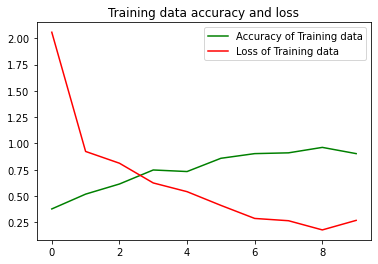

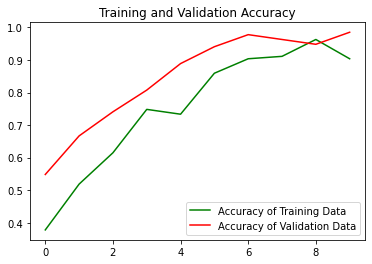

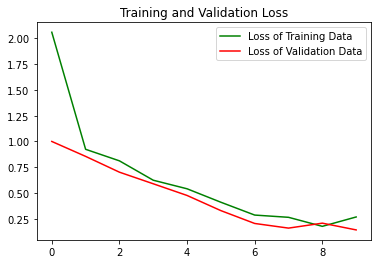

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
y_pred=model.predict(test_ds)
y_pred

array([[5.87219894e-02, 4.92731296e-02, 8.92004848e-01],
       [9.85751688e-01, 8.97844788e-03, 5.26985107e-03],
       [2.10683630e-03, 9.97892916e-01, 2.94024147e-07],
       [9.81473744e-01, 6.89140148e-03, 1.16349207e-02],
       [3.97972297e-03, 9.96019304e-01, 9.44820442e-07],
       [9.88561213e-01, 9.32272174e-04, 1.05065834e-02],
       [9.36032757e-02, 3.63411680e-02, 8.70055616e-01],
       [1.32222055e-03, 5.68253029e-07, 9.98677194e-01],
       [7.24685742e-05, 9.99926209e-01, 1.34052937e-06],
       [5.89174160e-04, 2.21686904e-07, 9.99410629e-01],
       [9.97433603e-01, 2.45449389e-03, 1.11866531e-04],
       [4.87556048e-02, 9.37651992e-01, 1.35923671e-02],
       [8.72460723e-01, 1.26558289e-01, 9.81015735e-04],
       [1.68815538e-01, 7.44282603e-01, 8.69018957e-02],
       [7.27944355e-03, 7.02263147e-04, 9.92018282e-01],
       [1.02262581e-02, 2.75688106e-03, 9.87016857e-01],
       [2.76102811e-01, 6.98549628e-01, 2.53475476e-02],
       [7.33466027e-03, 2.71605

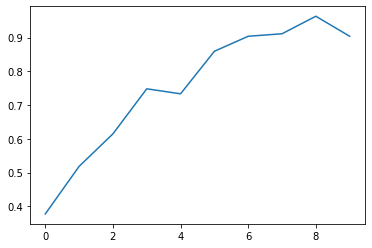

In [ ]:
d=hist.history
d.keys()
plt.plot(range(10),d['accuracy'])
############ epoch size range

In [ ]:
pred=model.predict(test_ds)

In [ ]:
p=np.argmax(pred,axis=1)

In [ ]:
img=[]
label=[]
for image_batch,label_batch in train_ds:
  img.append(image_batch)
  label.append(label_batch)

Timage=np.concatenate(img)
Tlabel=np.concatenate(label)
print(Timage.shape)
print(Tlabel.shape)

(135, 128, 128, 3)
(135,)


In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Tlabel,p)
cm

array([[25, 10, 10],
       [12, 18, 15],
       [ 8, 18, 19]])

(128, 128, 3)


Text(0.5, 1.0, 'daisy')

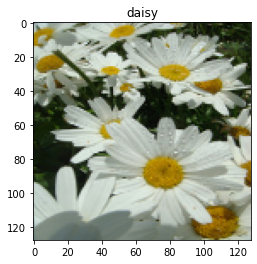

In [ ]:
i=100
im=Timage[i]
L=Tlabel[i]
print(im.shape)
plt.imshow(im/255)
plt.title(class_names[L])

In [ ]:
print(im.shape)
im1=tf.expand_dims(im,axis=0)
print(im1.shape)

(128, 128, 3)
(1, 128, 128, 3)


In [ ]:
P=model.predict(im1)
P
print('Prob=',np.max(P[0]))
print('Label=',np.argmax(P[0]))
print('Class=',class_names[np.argmax(P[0])])

Prob= 0.7039533
Label= 0
Class= daisy


In [ ]:
url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQqOxHCcwPlBipUtl455vCh88FxuclJ1L-86w&usqp=CAU'

##### copied image from internet inorder to match if the same is present in our dataset or not


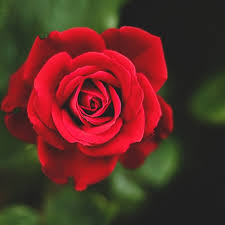

In [ ]:
# Read an image
import PIL
dir='/content/drive/MyDrive/Flower Dataset/rose.jfif'
PIL.Image.open(dir)

(113, 113, 3)


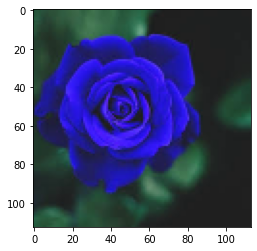

In [ ]:
import cv2
dir='/content/drive/MyDrive/Flower Dataset/rose.jfif'
img=cv2.imread(dir,20)

######### visuality color is different

print(img.shape)

import matplotlib.pyplot as plt
plt.imshow(img)

[[[0.20784314 0.30980393 0.1254902 ]
  [0.22745098 0.32941177 0.14509805]
  [0.23921569 0.34117648 0.15686275]
  ...
  [0.1254902  0.1254902  0.1254902 ]
  [0.1254902  0.1254902  0.1254902 ]
  [0.1254902  0.1254902  0.1254902 ]]

 [[0.20784314 0.30980393 0.1254902 ]
  [0.22745098 0.32941177 0.14509805]
  [0.23921569 0.34117648 0.15686275]
  ...
  [0.1254902  0.1254902  0.1254902 ]
  [0.1254902  0.1254902  0.1254902 ]
  [0.1254902  0.1254902  0.1254902 ]]

 [[0.21176471 0.3137255  0.12941177]
  [0.23137255 0.33333334 0.14901961]
  [0.24313726 0.34509805 0.16078432]
  ...
  [0.1254902  0.1254902  0.1254902 ]
  [0.1254902  0.1254902  0.1254902 ]
  [0.1254902  0.1254902  0.1254902 ]]

 ...

 [[0.2627451  0.3764706  0.14901961]
  [0.25882354 0.37254903 0.15294118]
  [0.24705882 0.36078432 0.14901961]
  ...
  [0.12156863 0.12156863 0.12156863]
  [0.12156863 0.12156863 0.12156863]
  [0.12156863 0.12156863 0.12156863]]

 [[0.25490198 0.36862746 0.14117648]
  [0.24705882 0.36078432 0.14117648]


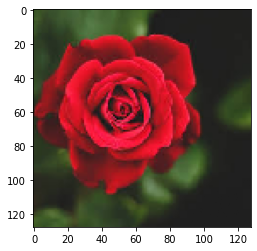

In [ ]:
#keras preprocessing layer
import tensorflow as tf
dir='/content/drive/MyDrive/Flower Dataset/rose.jfif'
img=tf.keras.preprocessing.image.load_img(dir,target_size=(128,128))
img=tf.keras.preprocessing.image.img_to_array(img)
img= img/255.0
print(img)
plt.imshow(img)   #float[0-1]
print(img.shape)

In [ ]:
im1= tf.expand_dims(img,axis=0)
print(im1.shape)
P=model.predict(im1)
P
print('Prob= ', np.max(P[0]))
print('Label = ', np.argmax(P[0]))
print('class= ', class_names[np.argmax(P[0])])

(1, 128, 128, 3)
Prob=  0.40692154
Label =  1
class=  dandelion


In [ ]:
# epoch=iteration